<a href="https://colab.research.google.com/github/o-semenkova/ml_home_tasks/blob/main/HW_2_2_%D0%9D%D0%B5%D0%B7%D0%B1%D0%B0%D0%BB%D0%B0%D0%BD%D1%81%D0%BE%D0%B2%D0%B0%D0%BD%D0%B0_%D0%B1%D0%B0%D0%B3%D0%B0%D1%82%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D0%BE%D0%B2%D0%B0_%D0%BA%D0%BB%D0%B0%D1%81%D0%B8%D1%84%D1%96%D0%BA%D0%B0%D1%86%D1%96%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [148]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay,
    roc_auc_score, f1_score
)

In [149]:
drive.mount('/content/drive')
base_df = pd.read_csv("/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/customer_segmentation_train.csv")
base_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [150]:
base_df.drop('ID', axis=1, inplace=True)

In [151]:
target_col_name = 'Segmentation'
X = base_df.drop(columns=target_col_name)
y = base_df[target_col_name]

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [153]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6454 entries, 917 to 2661
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           6454 non-null   object 
 1   Ever_Married     6343 non-null   object 
 2   Age              6454 non-null   int64  
 3   Graduated        6395 non-null   object 
 4   Profession       6348 non-null   object 
 5   Work_Experience  5808 non-null   float64
 6   Spending_Score   6454 non-null   object 
 7   Family_Size      6190 non-null   float64
 8   Var_1            6394 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 504.2+ KB


In [154]:
# Pandas nullable integer (підтримує NaN)
X_train['Family_Size'] = X_train['Family_Size'].astype("Int64")

In [155]:
str_flag_cols = ['Ever_Married', 'Graduated']
mapping = {'Yes': 1, 'No': 0}

for col in str_flag_cols:
    X_train[col] = X_train[col].map(mapping).astype('Int64')

In [156]:
# Для пайплайну

class ColumnTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, binary_flag_cols=None, int_cols=None, mapping={'Y': 1, 'N': 0}):
        self.binary_flag_cols = binary_flag_cols or []
        self.int_cols = int_cols or []
        self.mapping = mapping

    def fit(self, X, y=None):
        # Зберігаємо медіани для використання в transform
        self.medians = {}
        for col in self.int_cols:
            if col in X.columns:
                self.medians[col] = X[col].median()
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Конвертація binary flags
        for col in self.binary_flag_cols:
            if col in X_copy.columns:
                mapped_values = X_copy[col].map(self.mapping)
                # Заповнити NaN після mapping (якщо були невідомі значення)
                X_copy[col] = mapped_values.fillna(0).astype('Int64')

        # Конвертація в integer з медіаною
        for col in self.int_cols:
            if col in X_copy.columns:
                # Використовуємо збережену медіану з fit
                median_value = self.medians.get(col, 0)
                X_copy[col] = X_copy[col].fillna(median_value).astype('Int64')

        return X_copy

In [157]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6454 entries, 917 to 2661
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           6454 non-null   object 
 1   Ever_Married     6343 non-null   Int64  
 2   Age              6454 non-null   int64  
 3   Graduated        6395 non-null   Int64  
 4   Profession       6348 non-null   object 
 5   Work_Experience  5808 non-null   float64
 6   Spending_Score   6454 non-null   object 
 7   Family_Size      6190 non-null   Int64  
 8   Var_1            6394 non-null   object 
dtypes: Int64(3), float64(1), int64(1), object(4)
memory usage: 523.1+ KB


In [158]:
X_train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
917,Female,0,32,1,Artist,9.0,Low,1,Cat_6
3398,Male,1,72,1,Entertainment,NaN,Average,2,Cat_6
2045,Female,0,33,1,Entertainment,1.0,Low,4,Cat_6
8060,Female,1,48,1,Artist,0.0,Average,6,Cat_6
4604,Female,1,28,0,Doctor,9.0,Low,1,Cat_7


In [159]:
X_train.dtypes

,0
Gender,object
Ever_Married,Int64
Age,int64
Graduated,Int64
Profession,object
Work_Experience,float64
Spending_Score,object
Family_Size,Int64
Var_1,object


Аналіз збалансованості цільової змінної:
D              : 1814 ( 28.1%)
A              : 1578 ( 24.4%)
C              : 1576 ( 24.4%)
B              : 1486 ( 23.0%)
Загалом:        6454 (100.0%)

Коефіцієнт дисбалансу: 1.22
Найбільший клас: D (1814 зразків)
Найменший клас: B (1486 зразків)
✅ Датасет відносно збалансований


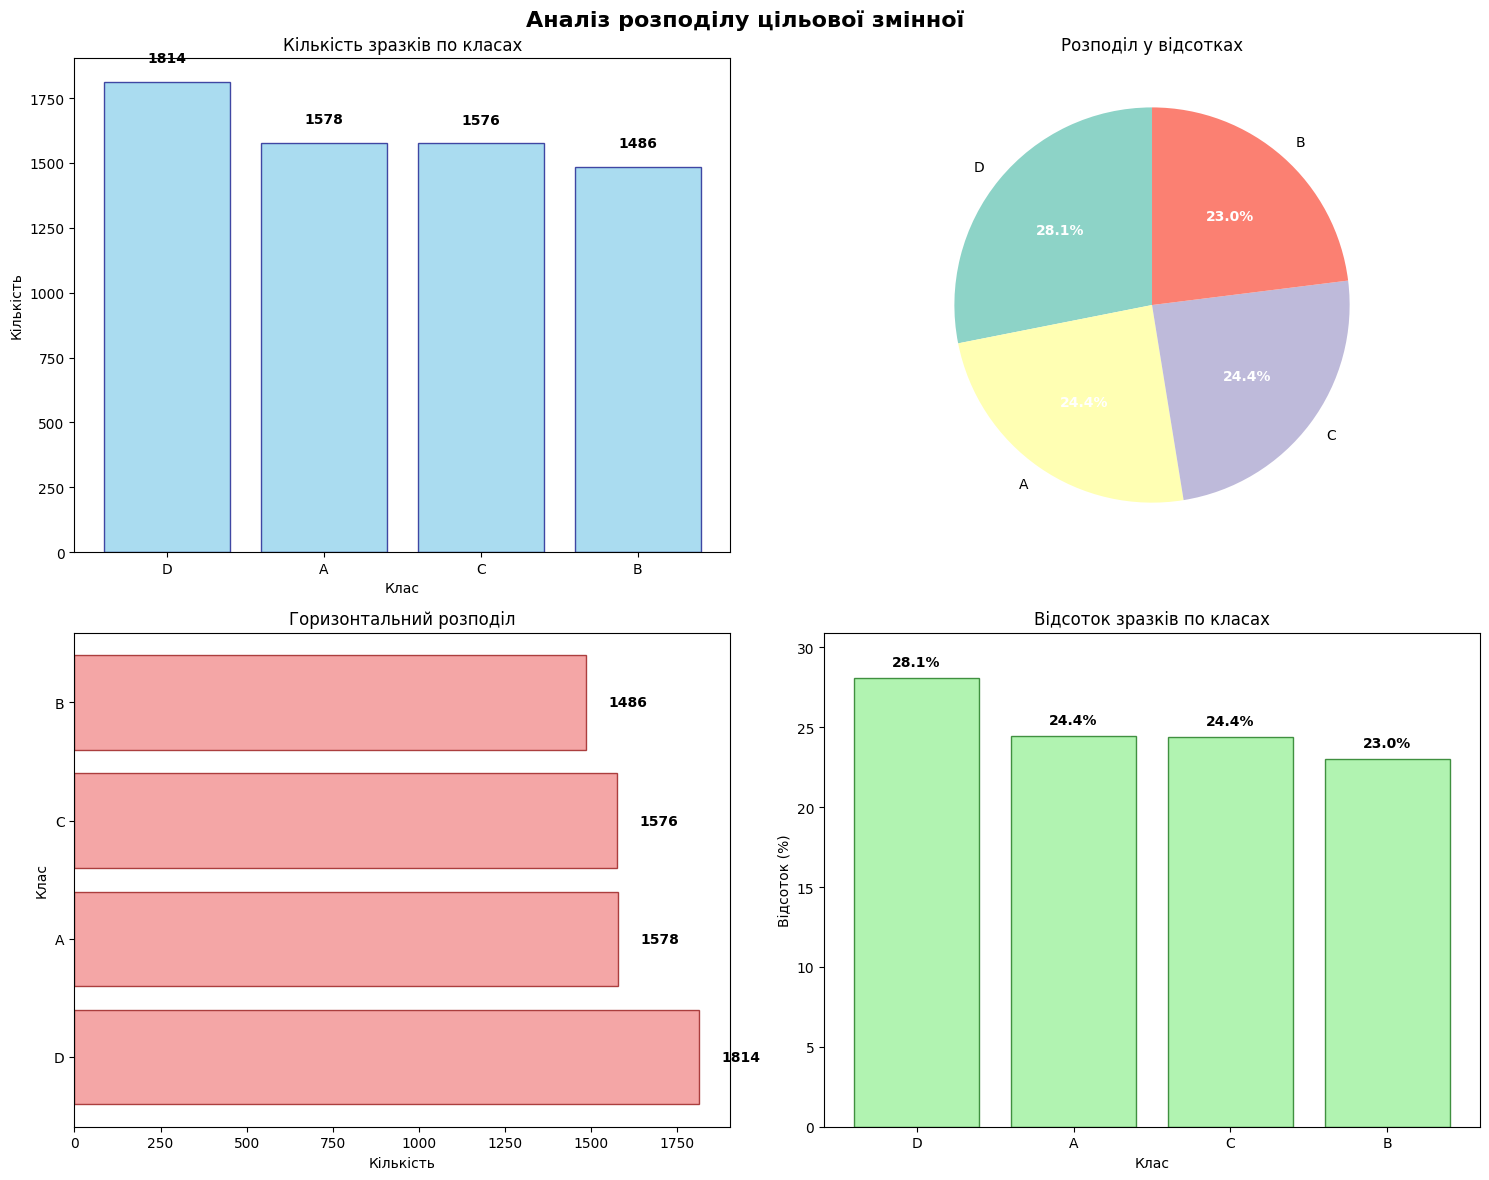


ДОДАТКОВА СТАТИСТИКА:
Клас  Кількість  Відсоток (%)  Відношення до найменшого
   D       1814         28.11                      1.22
   A       1578         24.45                      1.06
   C       1576         24.42                      1.06
   B       1486         23.02                      1.00

Рекомендації для моделювання:
• Можна використовувати стандартні підходи
• Accuracy буде репрезентативною метрикою


In [160]:
# Аналіз збалансованості класів
class_counts = pd.Series(y_train).value_counts()
total_samples = len(y_train)

print("Аналіз збалансованості цільової змінної:")
print("=" * 50)

for class_name, count in class_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{class_name:15}: {count:4d} ({percentage:5.1f}%)")

print("=" * 50)
print(f"Загалом:        {total_samples:4d} (100.0%)")

# Перевірка збалансованості
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"\nКоефіцієнт дисбалансу: {imbalance_ratio:.2f}")
print(f"Найбільший клас: {class_counts.index[0]} ({class_counts.iloc[0]} зразків)")
print(f"Найменший клас: {class_counts.index[-1]} ({class_counts.iloc[-1]} зразків)")

if imbalance_ratio > 3:
    print("⚠️  Датасет сильно незбалансований!")
    print("   Рекомендації: використати SMOTE, class_weight='balanced', або стратифіковану вибірку")
elif imbalance_ratio > 2:
    print("⚠️  Датасет помірно незбалансований")
    print("   Рекомендації: використати class_weight='balanced' або стратифіковану вибірку")
else:
    print("✅ Датасет відносно збалансований")

# Візуалізація
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Аналіз розподілу цільової змінної', fontsize=16, fontweight='bold')

# 1. Стовпчикова діаграма з кількістю
axes[0, 0].bar(class_counts.index.astype(str), class_counts.values,
               color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_title('Кількість зразків по класах')
axes[0, 0].set_xlabel('Клас')
axes[0, 0].set_ylabel('Кількість')
# Додаємо підписи значень на стовпчики
for i, v in enumerate(class_counts.values):
    axes[0, 0].text(i, v + total_samples*0.01, str(v),
                    ha='center', va='bottom', fontweight='bold')

# 2. Кругова діаграма з відсотками
colors = plt.cm.Set3(range(len(class_counts)))
wedges, texts, autotexts = axes[0, 1].pie(class_counts.values,
                                         labels=class_counts.index,
                                         autopct='%1.1f%%',
                                         colors=colors,
                                         startangle=90)
axes[0, 1].set_title('Розподіл у відсотках')

# Покращуємо читабельність тексту
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 3. Горизонтальна стовпчикова діаграма
axes[1, 0].barh(class_counts.index.astype(str), class_counts.values,
                color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[1, 0].set_title('Горизонтальний розподіл')
axes[1, 0].set_xlabel('Кількість')
axes[1, 0].set_ylabel('Клас')
# Додаємо підписи значень
for i, v in enumerate(class_counts.values):
    axes[1, 0].text(v + total_samples*0.01, i, str(v),
                    va='center', ha='left', fontweight='bold')

# 4. Стовпчикова діаграма з відсотками
percentages = (class_counts / total_samples) * 100
axes[1, 1].bar(class_counts.index.astype(str), percentages.values,
               color='lightgreen', edgecolor='darkgreen', alpha=0.7)
axes[1, 1].set_title('Відсоток зразків по класах')
axes[1, 1].set_xlabel('Клас')
axes[1, 1].set_ylabel('Відсоток (%)')
axes[1, 1].set_ylim(0, percentages.max() * 1.1)
# Додаємо підписи відсотків
for i, v in enumerate(percentages.values):
    axes[1, 1].text(i, v + percentages.max()*0.02, f'{v:.1f}%',
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Додаткова статистика
print("\n" + "="*50)
print("ДОДАТКОВА СТАТИСТИКА:")
print("="*50)

# Створюємо DataFrame для кращого відображення
stats_df = pd.DataFrame({
    'Клас': class_counts.index,
    'Кількість': class_counts.values,
    'Відсоток (%)': (class_counts.values / total_samples * 100).round(2),
    'Відношення до найменшого': (class_counts.values / min_count).round(2)
})

print(stats_df.to_string(index=False))

print(f"\nРекомендації для моделювання:")
if imbalance_ratio > 3:
    print("• Використати техніки семплінгу (SMOTE, ADASYN)")
    print("• Налаштувати class_weight='balanced' в моделі")
    print("• Використати стратифіковану кросвалідацію")
    print("• Розглянути метрики: F1-score, ROC-AUC, а не тільки accuracy")
elif imbalance_ratio > 2:
    print("• Налаштувати class_weight='balanced' в моделі")
    print("• Використати стратифіковану кросвалідацію")
    print("• Моніторити F1-score для кожного класу")
else:
    print("• Можна використовувати стандартні підходи")
    print("• Accuracy буде репрезентативною метрикою")

In [161]:
# Визначення колонок
original_categorical = ['Gender', 'Profession', 'Spending_Score', 'Var_1']
original_numeric = ['Age', 'Work_Experience']
binary_flags = ['Ever_Married', 'Graduated']
int_convert = ['Family_Size']
all_features = original_categorical + original_numeric + binary_flags + int_convert

# Виправлений full_preprocessor (для базової моделі)
full_preprocessor = ColumnTransformer([
    ('categorical', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', sparse_output=False))
    ]), original_categorical),
    ('numerical', SimpleImputer(strategy='median'), original_numeric + binary_flags + int_convert)
], remainder='drop').set_output(transform='pandas')

# Оригінальний preprocessor (для SMOTE моделей)
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(drop='first', sparse_output=False), original_categorical),
    ('numerical', 'passthrough', original_numeric + binary_flags + int_convert)
], remainder='drop').set_output(transform='pandas')

# Функція для підготовки даних
def prepare_data_for_resampling(X_train, X_test, y_train):
    type_converter = ColumnTypeConverter(
        binary_flag_cols=binary_flags,
        int_cols=int_convert
    )
    X_train_conv = type_converter.fit_transform(X_train)
    X_test_conv = type_converter.transform(X_test)

    # Імпутація
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train_conv[original_categorical] = cat_imputer.fit_transform(X_train_conv[original_categorical])
    X_test_conv[original_categorical] = cat_imputer.transform(X_test_conv[original_categorical])

    num_imputer = SimpleImputer(strategy='median')
    X_train_conv[original_numeric] = num_imputer.fit_transform(X_train_conv[original_numeric])
    X_test_conv[original_numeric] = num_imputer.transform(X_test_conv[original_numeric])

    # Конвертація типів для resampling
    for col in binary_flags + int_convert:
        X_train_conv[col] = X_train_conv[col].astype('int64')
        X_test_conv[col] = X_test_conv[col].astype('int64')

    return X_train_conv, X_test_conv

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [162]:
# Підготовка даних для SMOTE моделей
X_train_conv, X_test_conv = prepare_data_for_resampling(X_train, X_test, y_train)
categorical_indices = [i for i, col in enumerate(X_train_conv.columns) if col in original_categorical]

# === МОДЕЛЬ 1: БАЗОВА (БЕЗ RESAMPLING) ===
print("Навчання базової моделі...")
pipeline_baseline = Pipeline(steps=[
    ('type_converter', ColumnTypeConverter(binary_flag_cols=binary_flags, int_cols=int_convert)),
    ('preprocessor', full_preprocessor),
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
])

pipeline_baseline.fit(X_train, y_train)
y_pred_baseline = pipeline_baseline.predict(X_test)

# === МОДЕЛЬ 2: З SMOTENC ===
print("Навчання моделі з SMOTENC...")
smotenc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train_conv.values, y_train.values)
X_train_smotenc = pd.DataFrame(X_train_smotenc, columns=X_train_conv.columns)

X_train_smotenc_final = preprocessor.fit_transform(X_train_smotenc)
X_test_final = preprocessor.transform(X_test_conv)

classifier_smotenc = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
classifier_smotenc.fit(X_train_smotenc_final, y_train_smotenc)
y_pred_smotenc = classifier_smotenc.predict(X_test_final)

# === МОДЕЛЬ 3: З SMOTENC-TOMEK ===
print("Навчання моделі з SMOTENC-Tomek...")

# Спочатку SMOTENC
smotenc_step1 = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_temp_smotenc, y_temp_smotenc = smotenc_step1.fit_resample(X_train_conv.values, y_train.values)
X_temp_smotenc = pd.DataFrame(X_temp_smotenc, columns=X_train_conv.columns)

# Preprocessing для TomekLinks (конвертуємо все в числа)
X_temp_encoded = preprocessor.fit_transform(X_temp_smotenc)

# Потім TomekLinks на закодованих даних
tomek = TomekLinks()
X_train_smotetomek_final, y_train_smotetomek = tomek.fit_resample(X_temp_encoded, y_temp_smotenc)

# Для тестових даних використовуємо той же preprocessor
X_test_final = preprocessor.transform(X_test_conv)

classifier_smotetomek = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
classifier_smotetomek.fit(X_train_smotetomek_final, y_train_smotetomek)
y_pred_smotetomek = classifier_smotetomek.predict(X_test_final)


Навчання базової моделі...
Навчання моделі з SMOTENC...
Навчання моделі з SMOTENC-Tomek...


**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [163]:
# === ПОРІВНЯННЯ РЕЗУЛЬТАТІВ ===
print("\n" + "="*60)
print("ПОРІВНЯННЯ РЕЗУЛЬТАТІВ")
print("="*60)

print("\n1. БАЗОВА МОДЕЛЬ (без resampling):")
print("-" * 40)
print(classification_report(y_test, y_pred_baseline))

print("\n2. МОДЕЛЬ З SMOTENC:")
print("-" * 40)
print(classification_report(y_test, y_pred_smotenc))

print("\n3. МОДЕЛЬ З SMOTENC-TOMEK:")
print("-" * 40)
print(classification_report(y_test, y_pred_smotetomek))

# === ЗВЕДЕНА ТАБЛИЦЯ МЕТРИК ===
models_results = {
    'Модель': ['Базова', 'SMOTENC', 'SMOTENC-Tomek'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_smotenc),
        accuracy_score(y_test, y_pred_smotetomek)
    ],
    'Precision (macro)': [
        precision_score(y_test, y_pred_baseline, average='macro'),
        precision_score(y_test, y_pred_smotenc, average='macro'),
        precision_score(y_test, y_pred_smotetomek, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_test, y_pred_baseline, average='macro'),
        recall_score(y_test, y_pred_smotenc, average='macro'),
        recall_score(y_test, y_pred_smotetomek, average='macro')
    ],
    'F1 (macro)': [
        f1_score(y_test, y_pred_baseline, average='macro'),
        f1_score(y_test, y_pred_smotenc, average='macro'),
        f1_score(y_test, y_pred_smotetomek, average='macro')
    ]
}

comparison_df = pd.DataFrame(models_results)
print("\n" + "="*60)
print("ЗВЕДЕНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ")
print("="*60)
print(comparison_df.round(4))

# Визначення найкращої моделі
best_model_idx = comparison_df['F1 (macro)'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Модель']
best_f1_score = comparison_df.loc[best_model_idx, 'F1 (macro)']

print(f"\nНАЙКРАЩА МОДЕЛЬ: {best_model_name}")
print(f"F1-score (macro): {best_f1_score:.4f}")

# === АНАЛІЗ РОЗПОДІЛУ КЛАСІВ ===
print("\n" + "="*60)
print("АНАЛІЗ РОЗПОДІЛУ КЛАСІВ")
print("="*60)

print("Оригінальні дані:")
print(pd.Series(y_train).value_counts().sort_index())

print("\nПісля SMOTENC:")
print(pd.Series(y_train_smotenc).value_counts().sort_index())

print("\nПісля SMOTENC-Tomek:")
print(pd.Series(y_train_smotetomek).value_counts().sort_index())


ПОРІВНЯННЯ РЕЗУЛЬТАТІВ

1. БАЗОВА МОДЕЛЬ (без resampling):
----------------------------------------
              precision    recall  f1-score   support

           A       0.41      0.48      0.45       394
           B       0.48      0.19      0.27       372
           C       0.47      0.59      0.52       394
           D       0.63      0.72      0.67       454

    accuracy                           0.51      1614
   macro avg       0.50      0.49      0.48      1614
weighted avg       0.50      0.51      0.49      1614


2. МОДЕЛЬ З SMOTENC:
----------------------------------------
              precision    recall  f1-score   support

           A       0.41      0.49      0.45       394
           B       0.37      0.24      0.29       372
           C       0.50      0.55      0.52       394
           D       0.67      0.67      0.67       454

    accuracy                           0.50      1614
   macro avg       0.49      0.49      0.48      1614
weighted avg       0.